## News Filtering and Classification

The task is do build a **News Filtering System** that takes a set of news article from multiple sources, and decides whether each article should be pushed to the user. The aim is to design a methodology/pipeline that effectively filters relavant articles, particularly those impacting the reputation of the organizations of interest.

The notebook outlines various approaches that can used achieve this objective.

In [9]:
#imports
import os
os.chdir("..") 

import numpy as np
import pandas as pd
from src.data_processor import NewsProcessor
from src.embeddings import Word2VecEmbeddingGenerator

[nltk_data] Downloading package punkt to /Users/zhus22x/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhus22x/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/zhus22x/nltk_data...
/Users/zhus22x/miniconda/envs/news/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Approach 1: Filtering News Articles Based on Sentiment Polarity Scores

To filter relevant news articles, we analyze their sentiment polarity using **TextBlob**, a natural language processing (NLP) tool that assigns a polarity score to textual content. The sentiment polarity score ranges from **-1 (negative sentiment) to +1 (positive sentiment)**, with scores around **0 indicating neutrality**.

##### Step 1: Load and preprocess data

In [12]:
file_path = "data/raw/signal-1m-nasa.jsonl"

In [13]:
data_processor = NewsProcessor() # NewProcessor instance

# Load data from json file
news_df = data_processor.load_data(file_path=file_path)

# Preprocess text: convert to lowercase
news_df = data_processor.preprocess_text(data=news_df)

print(f"No. of news articles : ", len(news_df))

Error loading data from data/raw/signal-1m-nasa.jsonl: Expected object or value
Error during text preprocessing: 'content'
No. of news articles :  0


/Users/zhus22x/Documents/workspace/NewsFilter/src/data_processor.py:46: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  return pd.read_json(file_path, lines=True)


##### Step 2: Filter Articles by Keywords

In [4]:
# Filter articles containing relevant keywords
target_keywords = ["nasa", "space", "rocket"]
news_df = data_processor.filter_by_keyword(news_df, target_keywords=target_keywords)
print(f"No. of filtered articles : {len(news_df)}")

No. of filtered articles : 3881


##### Step 3: Generating Sentiment Polarity Scores

Computes the sentiment polarity for each article by analyzing its text content with **TextBlob**.

In [5]:
# compute polarity and store it in new column i.e. polarity_scores.
news_df = data_processor.generate_polarity(news_df)

##### Step 4: Assigning Sentiment Labels

In order to assign sentiment labels to each article, first analyse the distribution of polarity scores to define the polarity threshold for each class.

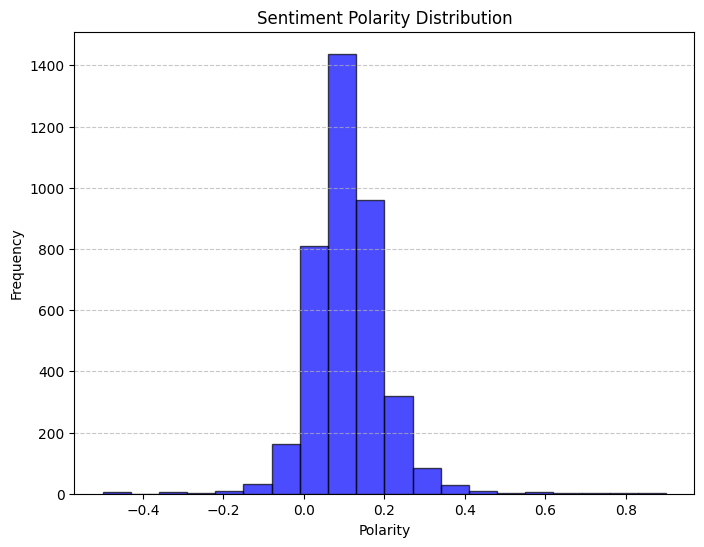

In [6]:
figure = data_processor.visualize_polarity_distribution(news_df)

Based on the analysis of polarity distribution, classify each article into three categories based on thresholds:
     
     - Negative Sentiment (-1): Polarity < -0.2
     - Neutral Sentiment (0): -0.2 ≤ Polarity ≤ 0.4
     - Positive Sentiment (1): Polarity > 0.4

In [7]:
# assign sentiment labels based on polarity threshold and store it in new column i.e. sentiment.
news_df = data_processor.generate_labels(news_df, polarity_thresholds=(-0.2, 0.4))

In [8]:
print('no of articles with positive sentiment : ', np.where(news_df["sentiment"] == 1)[0].shape)
print('no of articles with negative sentiment : ', np.where(news_df["sentiment"] == -1)[0].shape)
print('no of articles with neutral sentiment : ', np.where(news_df["sentiment"] == 0)[0].shape)

no of articles with positive sentiment :  (23,)
no of articles with negative sentiment :  (16,)
no of articles with neutral sentiment :  (3842,)


### Approach 2: Clustering

In [ ]:
download_url = ""
access_token = ""
filename = ""

In [ ]:
model_path = "data/models/models--fse--word2vec-google-news-300/snapshots/528f381952a0b7d777bb4a611c4a43f588d48994/word2vec-google-news-300.model"

In [ ]:
embedding_generator = Word2VecEmbeddingGenerator(pretrained_path = model_path)

#### Approach 2: Machine Learning modeling

##### 2.1 Unsupervised Learning

In [6]:
embedding_generator = Word2VecEmbeddingGenerator(model_path = "data/models/models--fse--word2vec-google-news-300/snapshots/528f381952a0b7d777bb4a611c4a43f588d48994/word2vec-google-news-300.model")

Loading pre-trained Word2Vec model : data/models/models--fse--word2vec-google-news-300/snapshots/528f381952a0b7d777bb4a611c4a43f588d48994/word2vec-google-news-300.model
Pre-trained Word2Vec model loaded successfully!


In [7]:
tokenized_texts = [content.split() for content in news_df["content"]]

In [8]:
embeddings = embedding_generator.generate_embeddings(tokenized_texts)

In [9]:
labels = news_df.get("label", [0] * len(news_df))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42, stratify=labels)

In [11]:
np.unique(y_train)

array([0, 1, 2])

In [12]:
np.unique(y_test)

array([0, 1, 2])

In [13]:
model = RandomForestClassifier().fit(X_train, y_train)

In [16]:
y_pred = model.predict(X_test)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Negative', 'Positive']))


Random Forest Evaluation:
              precision    recall  f1-score   support

     Neutral       0.99      1.00      1.00       769
    Negative       0.00      0.00      0.00         3
    Positive       1.00      0.20      0.33         5

    accuracy                           0.99       777
   macro avg       0.66      0.40      0.44       777
weighted avg       0.99      0.99      0.99       777



/usr/local/anaconda3/envs/news/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/anaconda3/envs/news/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/anaconda3/envs/news/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [6]:
from src.bert import BERTClassifier

In [7]:

# Train and Evaluate BERT model
bert_classifier = BERTClassifier()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
bert_trainer = bert_classifier.train(news_df["content"].tolist(), labels.tolist())

/usr/local/anaconda3/envs/news/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
